In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

some dependencies to get the dataset

In [ ]:
! pip install rarfile av
! pip install -Uq pyopenssl

# Tutorial - Using fastai on sequences of Images

> How to use fastai to train an image sequence to image sequence job.

This tutorial aims to use fastai to process sequences of images. 
- First we will do video classification on the UCF101 dataset. A seuqence of frames will be classified depicting a human action we will be classified.
- Second, we will predict future frames of MNIST digits moving on the screen.

In [ ]:
from fastai.vision.all import *

## UCF101 Action Recognition

> UCF101 is an action recognition data set of realistic action videos, collected from YouTube, having 101 action categories. This data set is an extension of UCF50 data set which has 50 action categories.

_"With 13320 videos from 101 action categories, UCF101 gives the largest diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it is the most challenging data set to date. As most of the available action recognition data sets are not realistic and are staged by actors, UCF101 aims to encourage further research into action recognition by learning and exploring new realistic action categories"_

### setup

We will download the UCF101 dataset from their website. It is a big dataset (6.5GB), if your connection is slow you may want to do this at night or in a terminal (to not block the notebook). the fastai `untar_data` is not capable of downloading this dataset, so we will use `wget` and then unrar the files using `rarfile`.

`fastai`'s datasets are located inside `~/.fastai/archive`, we will download our dataset next to them.

In [ ]:
#slow
# !wget -P ~/.fastai/archive/ --no-check-certificate  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar 

> you can run this command on a terminal to avoid blocking the notebook

here we make an `unrar` version of `untar_data` that is capable of extracting the UCF archive

In [ ]:
from rarfile import RarFile
    
def unrar(fname, dest):
    "Extract `fname` to `dest` using `rarfile`"
    dest = URLs.path(c_key='data')/fname.name.withsuffix('') if dest is None else dest
    print(f'extracting to: {dest}')
    if not dest.exists():
        fname = str(fname)
        if fname.endswith('rar'):  
            with RarFile(fname, 'r') as myrar:
                myrar.extractall(dest.parent)
        else: 
            raise Exception(f'Unrecognized archive: {fname}')
        rename_extracted(dest)
    return dest

extracted datasets are stored in `~/.fasta/data`, we will extract there

In [ ]:
ucf_fname = Path.home()/'.fastai/archive/UCF101.rar'
dest = Path.home()/'.fastai/data/UCF101'

In [ ]:
#slow
path = unrar(ucf_fname, dest)

extracting to: /home/tcapelle/.fastai/data/UCF101


we have a folder per action:

In [ ]:
path.ls()

(#101) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101/HorseRace'),Path('/home/tcapelle/.fastai/data/UCF101/FrontCrawl'),Path('/home/tcapelle/.fastai/data/UCF101/LongJump'),Path('/home/tcapelle/.fastai/data/UCF101/GolfSwing'),Path('/home/tcapelle/.fastai/data/UCF101/ApplyEyeMakeup'),Path('/home/tcapelle/.fastai/data/UCF101/UnevenBars'),Path('/home/tcapelle/.fastai/data/UCF101/HeadMassage'),Path('/home/tcapelle/.fastai/data/UCF101/Kayaking')...]

and `.avi` videos of each action inside the folders

We will need to convert each video to a sequence of images to able to work with our fastai vision toolset.

In [ ]:
video_paths = get_files(path, extensions='.avi')

In [ ]:
video_paths

(#13320) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g21_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g03_c03.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g18_c02.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g24_c06.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g13_c07.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g12_c02.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g13_c01.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g19_c01.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g24_c03.avi')...]

we can easily convert the videos to frames using `av`:

In [ ]:
import av

In [ ]:
def extract_frames(video_path):
    "convert video to PIL images "
    video = av.open(str(video_path))
    for frame in video.decode(0):
        yield frame.to_image()

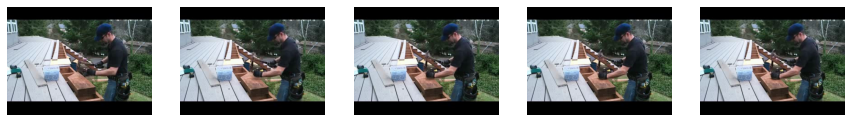

In [ ]:
frames = list(extract_frames(video_paths[0]))
show_images(frames[0:5])

In [ ]:
video_path = video_paths[0]
video_path

Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi')

we want to store the frames inside a folder of the same name

In [ ]:
video_path.relative_to(video_path.parent.parent).with_suffix('')

Path('Hammering/v_Hammering_g22_c05')

we will also create a new directory for our `frames` version of UCF

In [ ]:
path_frames = path.parent/'UCF101-frames'
if not path_frames.exists(): path_frames.mkdir()

we will make a function that takes a video path, and extracts the frames to our new `UCF-frames` dataset with the same folder structure.

In [ ]:
def avi2frames(video_path, path_frames=path_frames, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not dest_path.exists() or force:
        dest_path.mkdir(parents=True, exist_ok=True)
        for i, frame in enumerate(extract_frames(video_path)):
            frame.save(dest_path/f'{i}.jpg')

In [ ]:
avi2frames(video_path)

Now we can batch process the whole dataset using fastcore's `parallel`. This could be slow on a low CPU count machine. On a 12 core machine it takes 4 minutes.

In [ ]:
#slow
#parallel(avi2frames, video_paths)

after this you get a folder hierarchy that looks like this

```
UCF101-frames

├── ApplyEyeMakeup
|   |── v_ApplyEyeMakeup_g01_c01
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
|   ├── v_ApplyEyeMakeup_g01_c02
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
├── Hammering
|   ├── v_Hammering_g01_c01
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c02
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c03
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
...
├── YoYo
    ├── v_YoYo_g01_c01
    │   ├── 0.jpg
    │   ├── 1.jpg
    │   ├── 2.jpg
    |   ...
    ├── v_YoYo_g25_c03
        ├── 0.jpg
        ├── 1.jpg
        ├── 2.jpg
        ...
        ├── 136.jpg
        ├── 137.jpg

```

### Data pipeline

we have converted all the videos to images, now we can start building our fastai data pieline

In [ ]:
data_path = Path.home()/'.fastai/data/UCF101-frames'
data_path.ls()[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HorseRace')]

we have one folder per action, and inside one folder per instance of the action. For instance for Hammering we get all instances of the action:

In [ ]:
data_path.ls()[0].ls()

(#140) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g07_c03'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g13_c07'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g24_c02'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g13_c06'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g03_c01'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g23_c03'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g24_c07'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g18_c01'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g19_c02')...]

In [ ]:
def get_sequence_paths(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

with this function we get individual instances of each action, **these are the image sequences that we need to clasiffy.**

In [ ]:
instances_path = get_sequence_paths(data_path)
instances_path[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g07_c03'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g13_c07')]

the images are inside each of the folders (we have to sort them by number). This video has 161 frames. The files are not presented sorted numrically, we will fix this.

In [ ]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [ ]:
instances_path[0].ls_sorted()

(#187) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/0.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/1.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/2.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/3.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/4.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/5.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/6.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/7.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/8.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/9.jpg')...]

let's grab the first 5 frames

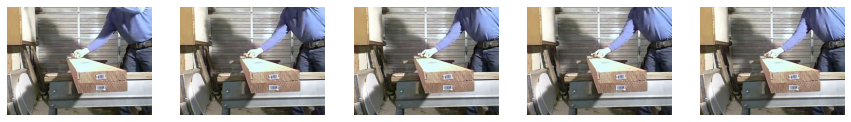

In [ ]:
frames = instances_path[0].ls_sorted()[0:5]
show_images([Image.open(img) for img in frames])

as a video can have many images, we will make a class that shows the 1st, middle and last images.

In [ ]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

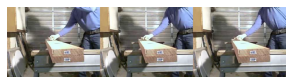

In [ ]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

we will use the mid-level API to create our Dataloader from a transformed list. 

In [ ]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
tfm = ImageTupleTfm(seq_len=5)
hammering_instance = instances_path[0]
hammering_instance

Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02')

<AxesSubplot:>

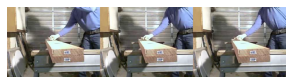

In [ ]:
tfm(hammering_instance).show()

with this setup, we can use the `parent_label` as our labelleing function

In [ ]:
parent_label(hammering_instance)

'Hammering'

In [ ]:
splits = RandomSplitter()(instances_path)

We will use a `Datasets`, we have to pass a `list` of transforms. The first list `[ImageTupleTfm(5)]` is how we grab the `x`'s and the second list `[parent_label, Categorize]]` is how we grab the `y`'s.' So, from each instance path, we grab the first 5 images to construct an `ImageTuple` and we grad the label of the action from the parent folder using `parent_label` and the we `Categorize` the labels.

In [ ]:
ds = Datasets(instances_path, tfms=[[ImageTupleTfm(5)], [parent_label, Categorize]], splits=splits)

In [ ]:
len(ds)

13320

In [ ]:
dls = ds.dataloaders(bs=4, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

refactoring

In [ ]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

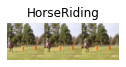

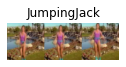

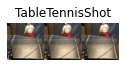

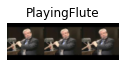

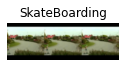

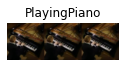

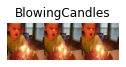

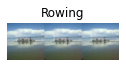

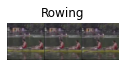

In [ ]:
dls = get_action_dataloaders(instances_path, bs=32, image_size=64, seq_len=5)
dls.show_batch()

### The Model

We will make a simple model, that will encoder each frame individually using a pretrained resnet. We make use of the `TimeDistributed` layer to apply the resnet to each frame identically. This simple model will just average the probabilities of each frame individually.

In [ ]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34, n_out=101):
        self.encoder = TimeDistributed(create_body(arch, pretrained=True))
        self.head = TimeDistributed(create_head(512, 101))
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)
    
def simple_splitter(model): return [params(model.encoder), params(model.head)]

In [ ]:
model = SimpleModel().cuda()

In [ ]:
x,y = dls.one_batch()

We get a tensor of `(bs, seq_len, features)`

we always check model outs before training

In [ ]:
model(x).shape

torch.Size([32, 101])

we make use of the `HalfPrecision` callback to speed up our training, also the `TimeDistributed` layer is memory hungry (it pivots the image sequence to the batch dimesion)

In [ ]:
learn = Learner(dls, model, metrics=[accuracy], splitter=simple_splitter).to_fp16()

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0006918309954926372)

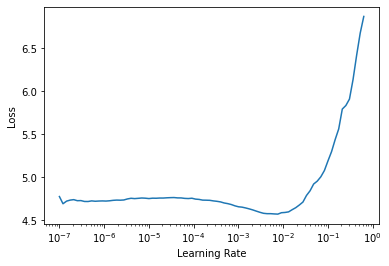

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,3.668002,3.229334,0.314189,00:19
1,2.427484,2.105770,0.492117,00:19
2,1.990548,1.744083,0.560435,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.460147,1.442050,0.631381,00:24
1,1.169836,1.241446,0.679805,00:24
2,0.952513,1.192215,0.687312,00:24


68% not bad for our simple baseline with only 5 frames.

We can improve our model by passing the outputs of the image encoder to an RNN to get some inter-frame relation. To do this, we have to get the features of the image encoder, so we have to modify our code and make use of the `create_body` function and add a pooling layer afterwards.

In [ ]:
arch = resnet34
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

if we check what the encoder does, for each image, we get a feature map of 512.

In [ ]:
encoder(x[0]).shape

(32, 512)

In [ ]:
tencoder = TimeDistributed(encoder)
tencoder(torch.stack(x, dim=1)).shape

(32, 5, 512)

this is perfect as input for a recurrent layer. Let's refactor and add a linear layer at the end. We will output the hidden state to a linear layer to compute the probabilities. The idea behind, is that the hidden state encodes the temporal information of the sequence.

In [ ]:
class RNNModel(Module):
    def __init__(self, arch=resnet34, n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

let's make a splitter function to train the encoder and the rest separetely

In [ ]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [ ]:
model2 = RNNModel().cuda()

In [ ]:
model2(x).shape

torch.Size([32, 101])

In [ ]:
learn = Learner(dls, model2, metrics=[accuracy], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0012022644514217973)

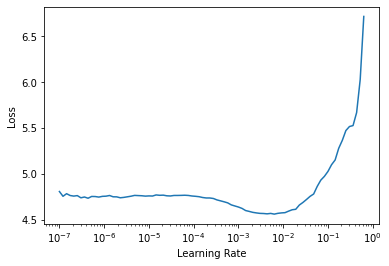

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.081921,2.968944,0.295796,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.965607,1.890396,0.516892,00:25
1,1.544786,1.648921,0.608108,00:24
2,1.007738,1.157811,0.702703,00:25
3,0.537038,0.885042,0.771772,00:24
4,0.351384,0.849636,0.781156,00:25


this models is harder to train. A good idea would be to add some Dropout. Let's try increasing the sequence lenght. Another approach would be to use a better layer for this type of task, like the [ConvLSTM](https://paperswithcode.com/method/convlstm) or a Transformer for images that are capable of modelling the spatio-temporal relations in a more sophisticated way.
Some ideas:
- Try sampling the frames differently, (randomly spacing, more frames, etc...)

## Moving MNIST

In this problem, the model has to predict the future frames of a sequence. We will solve a toy example where MNIST digits are moving on a canvas. This is an `ImageTuple` to `ImageTuple` task.

### setup

We are going to construct the dataset starting from the MNIST dataset available from fastai.

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
files = get_image_files(path/'training')

In [ ]:
img = Image.open(files[0])
timg = TensorImage(img)

In [ ]:
timg.show();

We will define some constants to work with.
- `digit_size`: is the resolution of the MNIST images (28x28)
- `image_size`: is the canvas size (64x64)
- `step_length`: is the "speed" of the moving digits on the canvas

In [ ]:
digit_size = 28
image_size = 64
step_length = 0.2
N = len(files)

we first have to create random trayectories of the (28x28) digits on the canvas, we will make them bounce back when they hit a border. We will compute the trayectory of the corner of the digit.

In [ ]:
def get_random_trajectory(seq_length):
    "Generate a trajectory"
    canvas_size = image_size - digit_size
    x, y, v_x, v_y = np.random.random(4)
    out_x, out_y = [], []
    
    for i in range(seq_length):
        # Take a step along velocity.
        y += v_y * step_length
        x += v_x * step_length

        # Bounce off edges.
        if x <= 0:
            x = 0
            v_x = -v_x
        if x >= 1.0:
            x = 1.0
            v_x = -v_x
        if y <= 0:
            y = 0
            v_y = -v_y
        if y >= 1.0:
            y = 1.0
            v_y = -v_y
        out_x.append(x * canvas_size)
        out_y.append(y * canvas_size)

    return tensor(out_x, dtype=torch.uint8), tensor(out_y, dtype=torch.uint8)

In [ ]:
x,y = get_random_trajectory(10)
plt.plot(x,y)

let's grab a random image from the dataset

In [ ]:
from random import choice
def get_rand_img():
    "Get one digit randomly"
    img = load_image(choice(files))
    return TensorImage(img)

we will directly convert to a tensor, to work on the canvas.

In [ ]:
timg = get_rand_img()
timg.show();

to move the digit, we get one randomly and shift using the random trayectory.

In [ ]:
def generate_moving_digit(n_frames, image_size=64):
    "Move one digit on the canvas"
    digit_image = get_rand_img()
    xs, ys = get_random_trajectory(n_frames)
    canvas = torch.zeros((n_frames, 1, image_size, image_size), dtype=torch.uint8)
    for i,(x,y) in enumerate(zip(xs,ys)):
        canvas[i, 0, y:(y+digit_size),x:(x+digit_size)] = digit_image
    return canvas

In [ ]:
show_images(generate_moving_digit(5))

we can combine multiple digits with different trayectories at once.

In [ ]:
def generate_moving_digits(n_frames, digits=1):
    "generate multiple digits"
    return torch.stack([generate_moving_digit(n_frames) for n in range(digits)]).max(dim=0)[0]

In [ ]:
digits = generate_moving_digits(5, 2)
show_images(digits)

We are going to use the mid level APi, but as we already have a tensor, is very simple.

In [ ]:
class ImageSeq(fastuple):
    @classmethod
    def create(cls, t, cl_type=TensorImageBW):
        return cls(tuple(cl_type(im) for im in t))
    def show(self, ctx=None, **kwargs): 
        return show_image(torch.cat([t for t in self], dim=-1), ctx=ctx, **self[0]._show_args, figsize=(10,5), **kwargs)

In [ ]:
img_seq = ImageSeq.create(digits)

In [ ]:
img_seq.show();

we will create a simple function to split our sequence on (x,y) where the first `n_in` frames will serve as input and the last `n_out` frames as target.

In [ ]:
def get_items(n_in=3, n_out=3, n_digits=2):
    n_frames = n_in + n_out
    digits = generate_moving_digits(n_frames, n_digits)
    x, y = digits[0:n_in], digits[n_in:]
    return x, y

In [ ]:
class ImageSeqTransform(Transform):
    def __init__(self, n_in, n_out, n_digits=2, cl_type=TensorImageBW):
        store_attr()
        
    def encodes(self, idx):
        x, y = get_items(self.n_in, self.n_out, self.n_digits)
        return ImageSeq.create(x, self.cl_type), ImageSeq.create(y, self.cl_type)

as the images are generated on the fly, we pass a list of integers to the `TfmdLists` constructor that will only serve as a counting mechanism.

In [ ]:
idxs = range_of(10)
splits = [0,1,2,3,4,5,6,7], [8,9]

In [ ]:
tls = TfmdLists(idxs, ImageSeqTransform(3,3), splits=splits)

In [ ]:
dls = tls.dataloaders(bs=4, after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

In [ ]:
b = dls.one_batch()
explode_types(b)

In [ ]:
b[0][0].shape

### refactor 

In [ ]:
def get_dls(n_in, n_out, N=100, bs=4):
    idxs = range_of(N)
    splits = RandomSplitter()(idxs)
    tls = TfmdLists(idxs, ImageSeqTransform(n_in, n_out), splits=splits)
    return tls.dataloaders(bs=bs, after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

In [ ]:
dls = get_dls(3,3,N=1000, bs=4)

In [ ]:
@typedispatch
def show_batch(x:ImageSeq, y:ImageSeq, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n* 1.2)
    if ctxs is None: 
        _, ctxs = plt.subplots(min(x[0].shape[0], max_n), ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        samples[i][0].show(ctx=ctx[0]), samples[i][1].show(ctx=ctx[1])

In [ ]:
dls.show_batch()

## Model